<a href="https://colab.research.google.com/github/Samvardhani/AgriAI/blob/main/LeftHand_predection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow pandas scikit-learn
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


In [ ]:
left_hand_path = '/content/drive/MyDrive/Combo Square/left_hand'
right_hand_path = '/content/drive/MyDrive/Combo Square/right_hand'
csv_path = '/content/drive/MyDrive/Combo Square/HandInfo.csv'

df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()


In [ ]:
def get_image_path(row):
    img_name = row['imageName']
    if 'left' in row['aspectOfHand'].lower():
        return os.path.join(left_hand_path, img_name)
    else:
        return os.path.join(right_hand_path, img_name)

df['imagePath'] = df.apply(get_image_path, axis=1)
df['label'] = df['aspectOfHand'].apply(lambda x: 'left' if 'left' in x.lower() else 'right')

# Keep valid image paths
df = df[df['imagePath'].apply(os.path.exists)]


In [ ]:
train_df, val_df = train_test_split(df[['imagePath', 'label']], test_size=0.2, stratify=df['label'], random_state=42)


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, x_col='imagePath', y_col='label',
    target_size=(299, 299),
    class_mode='binary',
    batch_size=32
)

val_gen = datagen.flow_from_dataframe(
    val_df, x_col='imagePath', y_col='label',
    target_size=(299, 299),
    class_mode='binary',
    batch_size=32
)


Found 2841 validated image filenames belonging to 2 classes.
Found 711 validated image filenames belonging to 2 classes.


In [ ]:
def build_and_train(model_name='inception'):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) \
        if model_name == 'inception' else \
        Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(train_gen, validation_data=val_gen, epochs=5)

    return model, history


In [ ]:
print("Training InceptionV3...")
inception_model, inception_history = build_and_train('inception')

print("Training Xception...")
xception_model, xception_history = build_and_train('xception')


Training InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6255 - loss: 0.6348 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 1207s 13s/step - accuracy: 0.6267 - loss: 0.6339 - val_accuracy: 0.8340 - val_loss: 0.4397
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 43s 482ms/step - accuracy: 0.8395 - loss: 0.4268 - val_accuracy: 0.8692 - val_loss: 0.3543
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 471ms/step - accuracy: 0.8805 - loss: 0.3437 - val_accuracy: 0.8889 - val_loss: 0.3102
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 469ms/step - accuracy: 0.8908 - loss: 0.3193 - val_accuracy: 0.9100 - val_loss: 0.2794
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 496ms/step - accuracy: 0.9099 - loss: 0.2772 - val_accuracy: 0.8931 - val_loss: 0.2812
Training Xception...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 88s 751ms/step - accuracy: 0.5770 - loss: 0.6765 - val_accuracy: 0.8143 - val_loss: 0.5499
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 46s 512ms/step - accuracy: 0.7620 - loss: 0.5506 - val_accuracy: 0.8284 - val_loss: 0.4817
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 46s 5

In [ ]:
inception_acc = max(inception_history.history['val_accuracy'])
xception_acc = max(xception_history.history['val_accuracy'])

print(f"InceptionV3 Max Val Accuracy: {inception_acc}")
print(f"Xception Max Val Accuracy: {xception_acc}")

best_model = inception_model if inception_acc > xception_acc else xception_model
print("✅ Best Model:", "InceptionV3" if best_model == inception_model else "Xception")


InceptionV3 Max Val Accuracy: 0.9099859595298767
Xception Max Val Accuracy: 0.900140643119812
✅ Best Model: InceptionV3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


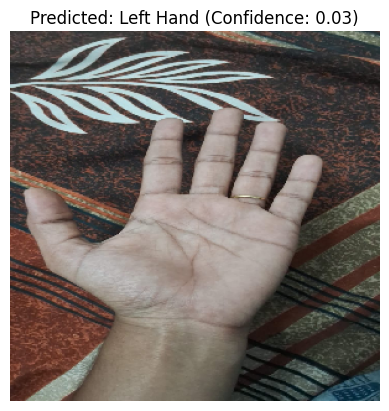

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_hand(img_path, model):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    # Predict
    prediction = model.predict(img_array)[0][0]
    label = "Right Hand" if prediction > 0.5 else "Left Hand"

    # Display result
    plt.imshow(img)  # Just use PIL image directly here
    plt.title(f"Predicted: {label} (Confidence: {prediction:.2f})")
    plt.axis('off')
    plt.show()

# Run prediction on your given sample image
sample_image_path = '/content/samplehand.jpg'
predict_hand(sample_image_path, best_model)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam


In [ ]:
def build_efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze base

    model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
left_hand_path = '/content/drive/MyDrive/Combo Square/left_hand'
right_hand_path = '/content/drive/MyDrive/Combo Square/right_hand'
csv_path = '/content/drive/MyDrive/Combo Square/HandInfo.csv'

# Load CSV
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # Clean column names

# Construct image paths
def get_image_path(row):
    img_name = row['imageName']
    if 'left' in row['aspectOfHand'].lower():
        return os.path.join(left_hand_path, img_name)
    else:
        return os.path.join(right_hand_path, img_name)

df['imagePath'] = df.apply(get_image_path, axis=1)
df['label'] = df['aspectOfHand'].apply(lambda x: 'left' if 'left' in x.lower() else 'right')

# Keep valid files
df = df[df['imagePath'].apply(os.path.exists)]

# Train/test split
train_df, val_df = train_test_split(df[['imagePath', 'label']], test_size=0.2, stratify=df['label'], random_state=42)

# Image generators
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='imagePath',
    y_col='label',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='imagePath',
    y_col='label',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)


Found 2841 validated image filenames belonging to 2 classes.
Found 711 validated image filenames belonging to 2 classes.


In [ ]:
history_efficient = efficientnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5039 - loss: 0.6959

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 912s 10s/step - accuracy: 0.5040 - loss: 0.6959 - val_accuracy: 0.4951 - val_loss: 0.6932
Epoch 2/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 474ms/step - accuracy: 0.5280 - loss: 0.6941 - val_accuracy: 0.4951 - val_loss: 0.6949
Epoch 3/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.5007 - loss: 0.6931 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 4/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 41s 463ms/step - accuracy: 0.5145 - loss: 0.6931 - val_accuracy: 0.5049 - val_loss: 0.6938
Epoch 5/5
89/89 ━━━━━━━━━━━━━━━━━━━━ 42s 471ms/step - accuracy: 0.4926 - loss: 0.6954 - val_accuracy: 0.5049 - val_loss: 0.6936


In [ ]:
best_val_acc = max(history_efficient.history['val_accuracy'])
print(f"✅ Best Validation Accuracy: {best_val_acc:.4f}")


✅ Best Validation Accuracy: 0.5049


In [ ]:
loss, acc = efficientnet_model.evaluate(val_gen)
print(f"✅ Final Validation Accuracy: {acc:.4f}")



23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.5016 - loss: 0.6939
✅ Final Validation Accuracy: 0.5049


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

left_hand_path = '/content/drive/MyDrive/Combo Square/left_hand'
right_hand_path = '/content/drive/MyDrive/Combo Square/right_hand'
csv_path = '/content/drive/MyDrive/Combo Square/HandInfo.csv'

df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

def get_image_path(row):
    img_name = row['imageName']
    if 'left' in str(row['aspectOfHand']).lower():
        return os.path.join(left_hand_path, img_name)
    else:
        return os.path.join(right_hand_path, img_name)

df['imagePath'] = df.apply(get_image_path, axis=1)
df['label'] = df['aspectOfHand'].astype(str).str.lower().apply(lambda x: 'left' if 'left' in x else 'right')
df = df[df['imagePath'].apply(os.path.exists)]


In [ ]:
print(df['label'].value_counts())

train_df, val_df = train_test_split(df[['imagePath', 'label']], test_size=0.2, stratify=df['label'], random_state=42)


label
right    1793
left     1759
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_dataframe(
    train_df, x_col='imagePath', y_col='label',
    target_size=(299, 299), class_mode='binary', batch_size=32
)

val_gen = val_aug.flow_from_dataframe(
    val_df, x_col='imagePath', y_col='label',
    target_size=(299, 299), class_mode='binary', batch_size=32
)


Found 2841 validated image filenames belonging to 2 classes.
Found 711 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Unfreeze last few layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_gen, validation_data=val_gen, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6441 - loss: 0.6240

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.6450 - loss: 0.6231 - val_accuracy: 0.5049 - val_loss: 0.7076
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.8421 - loss: 0.3429 - val_accuracy: 0.5921 - val_loss: 0.6936
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9179 - loss: 0.2065 - val_accuracy: 0.4951 - val_loss: 0.6946
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9469 - loss: 0.1422 - val_accuracy: 0.4965 - val_loss: 0.6740
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9511 - loss: 0.1182 - val_accuracy: 0.4951 - val_loss: 0.7959
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9706 - loss: 0.0780 - val_accuracy: 0.4937 - val_loss: 0.7193
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9792 - loss: 0.0591 - val_accuracy: 0.5415 - val_loss: 0.9944
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9756 - loss: 0.0588 - val_accuracy: 0.5724 - val_loss: 1.3658

In [ ]:
val_acc = max(history.history['val_accuracy'])
print(f"✅ Final Val Accuracy: {val_acc:.4f}")

model.save('/content/drive/MyDrive/Combo Square/final_best_model.h5')


✅ Final Val Accuracy: 0.8762


Enter full image path: /content/samplehand2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129306 (\N{RAISED BACK OF HAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


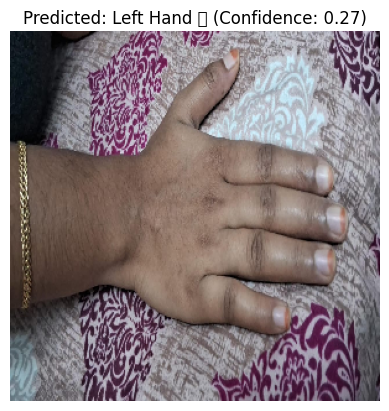

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load your saved model
model_path = '/content/drive/MyDrive/Combo Square/final_best_model.h5'
model = load_model(model_path)

# Predict function
def predict_user_image(img_path):
    try:
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Prediction
        prediction = model.predict(img_array)[0][0]
        label = "Right Hand 🖐️" if prediction > 0.5 else "Left Hand 🤚"

        # Show result
        plt.imshow(img)
        plt.title(f"Predicted: {label} (Confidence: {prediction:.2f})")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print("❌ Error processing image:", e)

# 👇 User input here (example image path)
user_image_path = input("Enter full image path: ")

# Run prediction
predict_user_image(user_image_path)


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

left_hand_path = '/content/drive/MyDrive/Combo Square/left_hand'
right_hand_path = '/content/drive/MyDrive/Combo Square/right_hand'
csv_path = '/content/drive/MyDrive/Combo Square/HandInfo.csv'

# Load CSV
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # Clean column names

# Create image paths
def get_image_path(row):
    img_name = row['imageName']
    if 'left' in str(row['aspectOfHand']).lower():
        return os.path.join(left_hand_path, img_name)
    else:
        return os.path.join(right_hand_path, img_name)

df['imagePath'] = df.apply(get_image_path, axis=1)

# Correct labels
df['label'] = df['aspectOfHand'].astype(str).str.lower().apply(lambda x: 'left' if 'left' in x else 'right')
df = df[df['imagePath'].apply(os.path.exists)]

# Encode as binary for keras
df['label'] = df['label'].map({'left': 0, 'right': 1})


/tmp/ipython-input-19-3743031667.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].map({'left': 0, 'right': 1})


In [ ]:
train_df, val_df = train_test_split(df[['imagePath', 'label']], test_size=0.2, stratify=df['label'], random_state=42)


In [ ]:
# Don't convert to numbers
df['label'] = df['aspectOfHand'].astype(str).str.lower().apply(lambda x: 'left' if 'left' in x else 'right')


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Fine-tune last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    verbose=1
)


Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.4756 - loss: 0.7076 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.5122 - loss: 0.6926 - val_accuracy: 0.4951 - val_loss: 0.6959
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5041 - loss: 0.7006 - val_accuracy: 0.4951 - val_loss: 0.6932
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.4991 - loss: 0.6945 - val_accuracy: 0.5049 - val_loss: 0.6933
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.4976 - loss: 0.6963 - val_accuracy: 0.5049 - val_loss: 0.6933
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.4891 - loss: 0.6965 - val_accuracy: 0.5049 - val_loss: 0.6930
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.4752 - loss: 0.6972 - val_accuracy: 0.5049 - val_loss: 0.6931
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.4890 - loss: 0.6960 - val_accuracy: 0.5049 - val_lo

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [ ]:
left_hand_path = '/content/drive/MyDrive/Combo Square/left_hand'
right_hand_path = '/content/drive/MyDrive/Combo Square/right_hand'
csv_path = '/content/drive/MyDrive/Combo Square/HandInfo.csv'


In [ ]:
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()

# Clean aspect column and create labels
df['aspectOfHand'] = df['aspectOfHand'].astype(str).str.lower()
df['label'] = df['aspectOfHand'].apply(lambda x: 'left' if 'left' in x else 'right')

# Image paths
def get_image_path(row):
    if 'left' in row['label']:
        return os.path.join(left_hand_path, row['imageName'])
    else:
        return os.path.join(right_hand_path, row['imageName'])

df['imagePath'] = df.apply(get_image_path, axis=1)

# Filter only existing image files
df = df[df['imagePath'].apply(os.path.exists)]

# Check class balance
print(df['label'].value_counts())


label
right    1793
left     1759
Name: count, dtype: int64


In [ ]:
train_df, val_df = train_test_split(df[['imagePath', 'label']], test_size=0.2, stratify=df['label'], random_state=42)


In [ ]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_dataframe(
    train_df,
    x_col='imagePath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_gen = val_aug.flow_from_dataframe(
    val_df,
    x_col='imagePath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 2841 validated image filenames belonging to 2 classes.
Found 711 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Fine-tune last layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    verbose=1
)


NameError: name 'model' is not defined

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your paths
left_hand_path = '/content/drive/MyDrive/Combo Square/left_hand'
right_hand_path = '/content/drive/MyDrive/Combo Square/right_hand'
csv_path = '/content/drive/MyDrive/Combo Square/HandInfo.csv'

# Load and clean the CSV
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
df['aspectOfHand'] = df['aspectOfHand'].astype(str).str.lower()

# Assign labels
df['label'] = df['aspectOfHand'].apply(lambda x: 'left' if 'left' in x else 'right')

# Add image paths
def get_image_path(row):
    if 'left' in row['label']:
        return os.path.join(left_hand_path, row['imageName'])
    else:
        return os.path.join(right_hand_path, row['imageName'])

df['imagePath'] = df.apply(get_image_path, axis=1)

# Drop rows with missing files
df = df[df['imagePath'].apply(os.path.exists)]

# Split the dataset
train_df, val_df = train_test_split(df[['imagePath', 'label']], test_size=0.2, stratify=df['label'], random_state=42)

# Set up data generators
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='imagePath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='imagePath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 2841 validated image filenames belonging to 2 classes.
Found 711 validated image filenames belonging to 2 classes.


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# === Step 1: Define Paths ===
left_hand_path = '/content/drive/MyDrive/Combo Square/left_hand'
right_hand_path = '/content/drive/MyDrive/Combo Square/right_hand'
csv_path = '/content/drive/MyDrive/Combo Square/HandInfo.csv'

# === Step 2: Load CSV and Label ===
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()
df['aspectOfHand'] = df['aspectOfHand'].astype(str).str.lower()
df['label'] = df['aspectOfHand'].apply(lambda x: 'left' if 'left' in x else 'right')

def get_image_path(row):
    if 'left' in row['label']:
        return os.path.join(left_hand_path, row['imageName'])
    else:
        return os.path.join(right_hand_path, row['imageName'])

df['imagePath'] = df.apply(get_image_path, axis=1)
df = df[df['imagePath'].apply(os.path.exists)]

# === Step 3: Split Dataset ===
train_df, val_df = train_test_split(df[['imagePath', 'label']], test_size=0.2, stratify=df['label'], random_state=42)

# === Step 4: Create Data Generators ===
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='imagePath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='imagePath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# === Step 5: Build and Train ResNet50 ===
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Fine-tune only last 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile and train
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    verbose=1
)

# === Step 6: View Accuracy ===
val_acc = max(history.history['val_accuracy'])
print(f"✅ Best Validation Accuracy with ResNet50: {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.5891 - loss: 0.6764 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 1237s 14s/step - accuracy: 0.5895 - loss: 0.6761 - val_accuracy: 0.5063 - val_loss: 0.6876
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 941s 10s/step - accuracy: 0.6271 - loss: 0.6336 - val_accuracy: 0.6399 - val_loss: 0.6669
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 879s 10s/step - accuracy: 0.6227 - loss: 0.6314 - val_accuracy: 0.6864 - val_loss: 0.5696
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 881s 10s/step - accuracy: 0.6737 - loss: 0.6085 - val_accuracy: 0.4951 - val_loss: 1.0601
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 882s 10s/step - accuracy: 0.6618 - loss: 0.6039 - val_accuracy: 0.5035 - val_loss: 0.6768
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 869s 10s/step - accuracy: 0.6595 - loss: 0.6095 - val_accuracy: 0.7243 - val_loss: 0.5318
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 868s 10s/step - accuracy: 0.7001 - loss: 0.5796 - val_accuracy: 0.5246 - val_loss: 0.6670
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 861s 10s/step - accuracy: 0.6666 - loss: 0.5986 - val_accuracy: 0.6301 - val